# О проекте

- Заказчик 
repetit.ru
- Задача 
Разработать модель, которая по имеющейся информации о репетиторе и проведенных им занятий будет классифицировать репетиторов на платящих и неэффективных. Оценка качества модели будет производиться с использованием метрики F1.

## Признаки обмана,выявленные при ручной проверке


- Заказчик произвел ручную проверку репетиторов на предмет мошенничества (звонки клиентам и так далее). Выяснилось, что 20% обманывают нас так или иначе.
- Несоответствие цены в заявке, в анкете репетитора и реальной
- 1 занятие на ученика (соотношение к общему кол-ву занятий)
- Разная стоимость с разными учениками
- Разная стоимость уроков с одним учеником
- Стоят занятия в расписании, а оплат нет
- Когда у репетитора по разным ученикам оплаты рядом по времени, то он сам оплачивает
- Как часто заходит в приложение - если редко, то сам оплачивает
- Статус заявки договорились о занятиях, оплат нет более недели (и не перенесено)
- status в orders = 9
- lessons с amount_payed > 0 за последнюю неделю
- Ученик не отмечен как завершенный, а оплат нет 
- Репетитор отчитался, что провёл платное занятие, оплаты нет
- Цена ниже 500 р. в регионах, ниже 700 в мск


## Импорты

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from datetime import datetime

In [3]:
pd.options.mode.copy_on_write = True

In [4]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 
from sklearn.metrics import f1_score, make_scorer

In [5]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc, f1_score

from catboost import CatBoostClassifier, Pool, cv

In [6]:
random_state = 1984

In [7]:
#conda install pyarrow

## Особенности

- Я сразу начал делать анализ данных после загрузки данных, потому что решил, что даже первичный анализ конкретно этих даннных уже занимает много места, поэтому решил избежать дублирования и сделать изначальный анализ каждой таблицы сразу после ее загрузки. 
- Я изначально хочу сделать деревянную модель. Возможно, это у меня потом пройдет, но на данный момент мне хочется построить именно случайный лес, потому что он лучше всего объясняет причинность. 

# Загрузка и знакомство с данными

## Информация по репетиторам + таргет (teachers)

In [8]:
teachers = pd.read_feather('datasets/teachers.feather')

In [9]:
teachers

,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked
0,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0
1,153845,1111.0,884.085028,1082.0,0.358974,77.285714,956580.0,0
2,42869,505.0,2500.000000,184.0,0.142857,61.333333,460000.0,0
3,127280,442.0,1879.338843,363.0,0.150000,60.500000,682200.0,0
4,283905,694.0,1252.434457,534.0,0.257143,59.333333,668800.0,0
...,...,...,...,...,...,...,...,...
1651,294498,1.0,1500.000000,1.0,0.166667,1.000000,1500.0,0
1652,3619,1.0,1300.000000,1.0,0.111111,1.000000,1300.0,0
1653,238509,4.0,900.000000,1.0,0.071429,1.000000,900.0,1
1654,180353,1.0,1700.000000,1.0,0.100000,1.000000,1700.0,0


- id - айди репетитора 
- lessons_delivered - поставлено уроков
- mean_lesson_price - средняя стоимость уроков
- lessons_given - оплачено уроков
- lessons_started_fraction - процент начала занятий
- lessons_per_pupil - занятий на ученика
- money_recieved - получено денег
- blocked - целевой признак (active/blocked)

In [10]:
teachers.describe()

,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked
count,1656.000000,1656.000000,1656.000000,1656.000000,1656.000000,1656.000000,1.656000e+03,1656.000000
mean,195700.558575,177.651570,1509.636125,104.064614,0.194887,9.872112,1.750237e+05,0.336353
std,87667.530193,336.451272,908.722960,217.635955,0.135023,9.601426,4.850086e+05,0.472604
min,458.000000,1.000000,200.000000,1.000000,0.009901,1.000000,2.000000e+02,0.000000
25%,130185.500000,12.000000,994.880952,8.000000,0.105263,3.000000,9.000000e+03,0.000000
50%,210036.500000,54.000000,1350.308642,30.000000,0.166667,7.094017,4.310000e+04,0.000000
75%,276014.500000,207.500000,1852.012502,103.000000,0.250000,13.500000,1.483500e+05,1.000000
max,317531.000000,5690.000000,15000.000000,3788.000000,1.000000,78.166667,1.116220e+07,1.000000


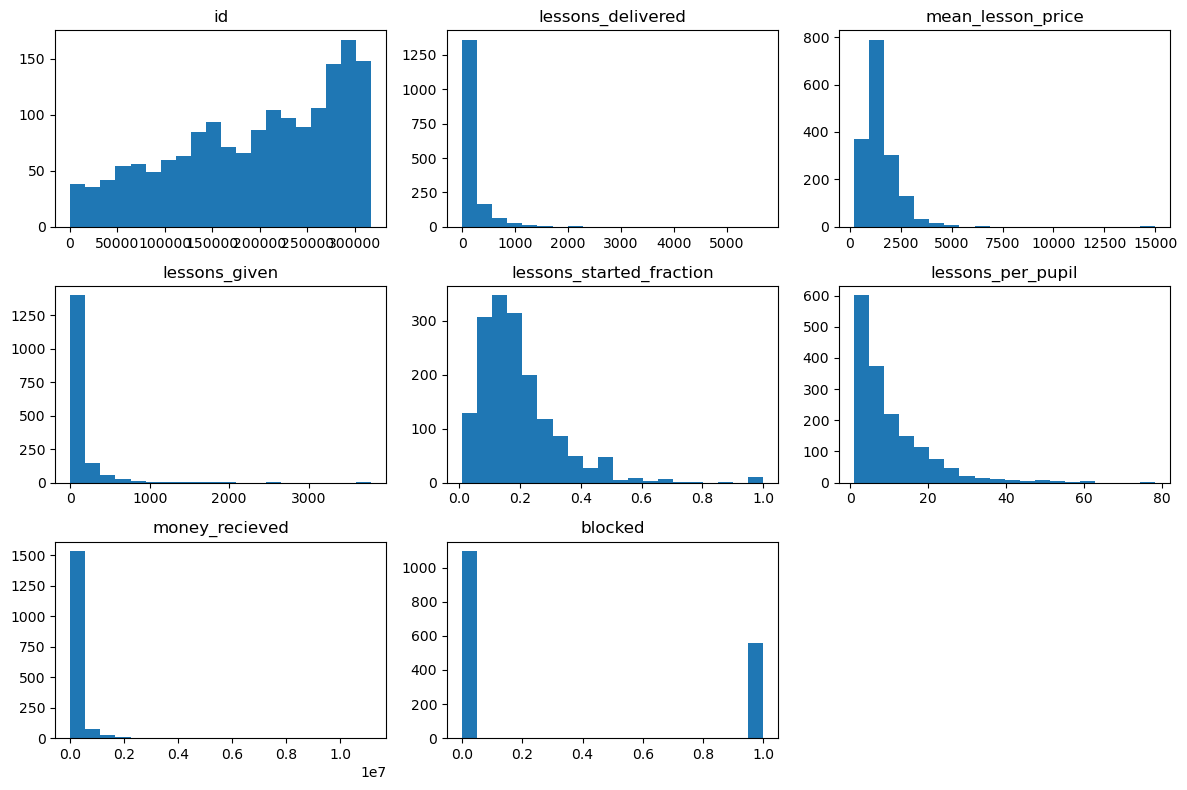

In [11]:
fig = plt.figure(figsize=(12, 8))

ax_list = []

nrows, ncols = (3, 3)

for i, column in enumerate(teachers.columns):
    ax = fig.add_subplot(nrows, ncols, i+1)
    ax.hist(teachers[column], bins = 20)
    plt.title(column)

plt.tight_layout()
plt.show()

Интересная колонка 'money_recieved' - медиана 43 000 рублей, а среднее 175 000 рублей, а wкто-то "принес" 11 162 000 рублей, да действительно, интересно.

Но на самом деле, скорее всего, этот же самый выброс (выбросы) фигурирую и в остальных колонках. Это мы сейчас и посмотрим. 

In [12]:
display(teachers[teachers['money_recieved']>=500000])

,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked
0,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0
1,153845,1111.0,884.085028,1082.0,0.358974,77.285714,956580.0,0
3,127280,442.0,1879.338843,363.0,0.150000,60.500000,682200.0,0
4,283905,694.0,1252.434457,534.0,0.257143,59.333333,668800.0,0
6,88923,1312.0,1776.096998,866.0,0.681818,57.733333,1538100.0,0
...,...,...,...,...,...,...,...,...
785,94612,755.0,2183.391003,289.0,0.205405,7.605263,631000.0,0
789,51112,128.0,4249.218750,128.0,0.153153,7.529412,543900.0,1
822,270768,383.0,1868.583618,293.0,0.182222,7.146341,547495.0,0
895,106332,204.0,3457.070707,198.0,0.135593,6.187500,684500.0,0


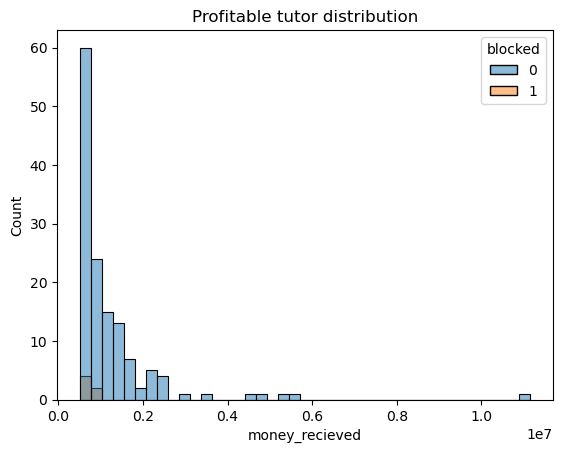

In [13]:
sns.histplot(x = 'money_recieved',
             data = teachers[teachers['money_recieved']>=500000],
            hue = 'blocked')
plt.title('Profitable tutor distribution')
plt.show()

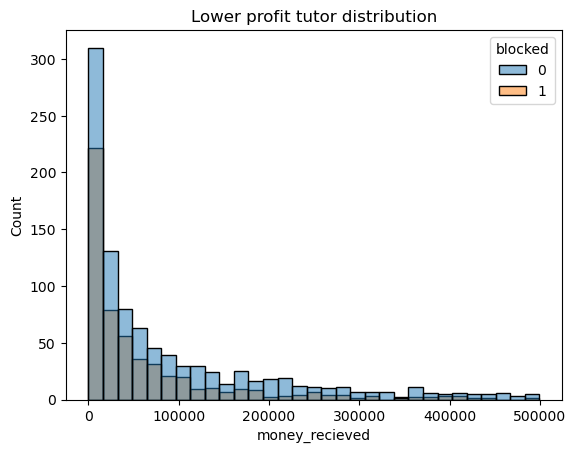

In [14]:
sns.histplot(x = 'money_recieved',
             data = teachers[teachers['money_recieved']<=500000],
            hue = 'blocked')
plt.title('Lower profit tutor distribution')
plt.show()

В целом, все кто принес больше 300 000 рублей - хорошие. Хотя бы с этим какая-то ясность.

Какую проблему я вижу сразу - у нас есть куча учителей, которы принесли меньше 20 тысяч рублей и они не отмечены неэффективными. А теперь давайте подумаем - человек заработал меньше 20 тысяч рублей за все время. И значит, провел меньше 20 уроков за все время. Но его каким-то образом оценили как успешного... В общем, прошу не ожидать от модеоли слишком многого. Я, конечно, попообую размазать это на срок, как, например среденее по месяцу, может, тогда что-то из этого и получится?

Теперь отдельно хочу взглянуть на дорогих учителей. 

In [15]:
display(teachers[teachers['mean_lesson_price']>=5000])

,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked
653,125489,215.0,6627.272727,55.0,0.461538,9.166667,364500.0,0
742,114012,55.0,14625.000000,8.0,0.030303,8.000000,117000.0,1
913,45382,32.0,5050.000000,30.0,0.192308,6.000000,151500.0,0
914,282114,6.0,5066.666667,6.0,0.111111,6.000000,30400.0,0
1032,71014,110.0,6150.000000,10.0,0.200000,5.000000,61500.0,0
1083,78354,9.0,5000.000000,9.0,0.095238,4.500000,45000.0,1
1163,12728,12.0,5000.000000,11.0,0.187500,3.666667,55000.0,1
1253,210973,13.0,5000.000000,9.0,0.166667,3.000000,45000.0,0
1267,212159,70.0,5468.627451,51.0,0.118881,3.000000,278900.0,1
1278,207140,265.0,8195.588235,34.0,0.093023,2.833333,278650.0,1


Мое первоначальное ощущение, что дорогие учителя будут эффективны не потвердило себя.

В общем, пока сложно сделать полноценные какие-то выводы, но точно можно сказать, что будет очень сложно получить высокий показатель качества модели. 

## Общая информация по репетиторам (teachers_info)

In [16]:
teachers_info = pd.read_feather('datasets/teachers_info.feather')

In [17]:
teachers_info

,id,reg_date,birth_date,teaching_start_date,is_email_confirmed,lesson_duration,lesson_cost,is_display,last_visited,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num
0,33,2007-12-24 19:26:46.000,1983-06-05 00:00:00.000,1989-09-01 00:00:00.000,0,60,1000,1,2022-10-24 16:48:38.410,1.0,0,1,1,0,6
1,46,2007-12-24 19:26:46.000,1980-02-12 00:00:00.000,2003-09-01 00:00:00.000,0,60,500,0,None,1.0,0,1,3,1,0
2,51,2007-12-24 19:26:46.000,1965-04-30 00:00:00.000,1988-09-01 00:00:00.000,0,60,1500,0,2022-09-26 09:43:56.123,1.0,0,1,2,1,0
3,52,2007-12-24 19:26:46.000,1988-07-06 00:00:00.000,2006-09-01 00:00:00.000,0,60,1000,1,2020-04-03 15:53:50.867,0.0,0,1,2,1,2
4,54,2007-12-24 19:26:46.000,1985-09-30 00:00:00.000,2004-01-01 00:00:00.000,0,45,400,0,None,1.0,0,1,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307967,312618,2023-11-07 13:46:11.707,1977-07-04 00:00:00.000,1999-09-01 00:00:00.000,0,60,0,1,None,NaN,0,18,2,0,0
307968,312619,2023-11-07 13:49:38.663,1980-06-14 00:00:00.000,2017-09-01 00:00:00.000,0,60,0,1,None,NaN,0,1,2,0,0
307969,312620,2023-11-07 14:20:23.607,2004-06-03 00:00:00.000,2022-09-01 00:00:00.000,0,60,0,1,None,NaN,0,1,2,1,0
307970,312621,2023-11-07 14:22:37.887,1999-08-08 00:00:00.000,2021-09-01 00:00:00.000,0,60,0,1,None,NaN,0,1,2,1,0


In [18]:
teachers_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307972 entries, 0 to 307971
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       307972 non-null  int64  
 1   reg_date                 307972 non-null  object 
 2   birth_date               307972 non-null  object 
 3   teaching_start_date      307972 non-null  object 
 4   is_email_confirmed       307972 non-null  int64  
 5   lesson_duration          307972 non-null  int64  
 6   lesson_cost              307972 non-null  int64  
 7   is_display               307972 non-null  int64  
 8   last_visited             235837 non-null  object 
 9   is_pupils_needed         11208 non-null   float64
 10  is_cell_phone_confirmed  307972 non-null  int64  
 11  area_id                  307972 non-null  int64  
 12  sex                      307972 non-null  int64  
 13  orders_allowed           307972 non-null  int64  
 14  revi

In [19]:
teachers_info['reg_date'] = pd.to_datetime(teachers_info['reg_date'], format='%Y-%m-%d %H:%M:%S.%f').dt.date
teachers_info['birth_date'] = pd.to_datetime(teachers_info['birth_date'], format='%Y-%m-%d %H:%M:%S.%f').dt.date
teachers_info['teaching_start_date'] = pd.to_datetime(teachers_info['teaching_start_date'], format='%Y-%m-%d %H:%M:%S.%f').dt.date
teachers_info['last_visited'] = pd.to_datetime(teachers_info['last_visited'], format='%Y-%m-%d %H:%M:%S.%f').dt.date


* id - айди репетитора 
* reg_date - дата регистрации
* birth_date - дата рождения
* teaching_start_date - дата начала первого занятия
* is_email_confirmed - подтвержден ли e-mail адресс
* lesson_duration - продолжит урока
* lesson_cost - стоимость урока
* is_display - показывается в каталоге
* last_visited - послеждний визит
* is_pupils_needed - открыт для заявок
* is_cell_phone_confirmed - подтвержден ли номер телефона
* area_id - регион 
* sex - пол 
* orders_allowed - разрешено назначать на заявки
* review_num - отзывы

In [20]:
teachers_info.describe()

,id,is_email_confirmed,lesson_duration,lesson_cost,is_display,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num
count,307972.000000,307972.000000,307972.000000,3.079720e+05,307972.000000,11208.000000,307972.000000,307972.000000,307972.000000,307972.000000,307972.000000
mean,157246.177036,0.012732,61.502978,5.325806e+02,0.658735,0.948162,0.006910,8.488928,1.776892,0.860702,1.087859
std,90198.005463,0.112114,15.061675,2.146357e+03,0.474135,0.221710,0.082837,16.442877,0.467861,0.346258,4.863274
min,33.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,79390.750000,0.000000,60.000000,0.000000e+00,0.000000,1.000000,0.000000,1.000000,2.000000,1.000000,0.000000
50%,157384.500000,0.000000,60.000000,5.000000e+02,1.000000,1.000000,0.000000,1.000000,2.000000,1.000000,0.000000
75%,235434.250000,0.000000,60.000000,9.000000e+02,1.000000,1.000000,0.000000,6.000000,2.000000,1.000000,0.000000
max,312622.000000,1.000000,999.000000,1.021709e+06,1.000000,1.000000,1.000000,121.000000,3.000000,1.000000,381.000000


In [21]:
selected_columns = teachers_info.columns

In [22]:
selected_columns = selected_columns.drop(
    ['id', 'reg_date', 'birth_date', 'teaching_start_date', 'last_visited']
)

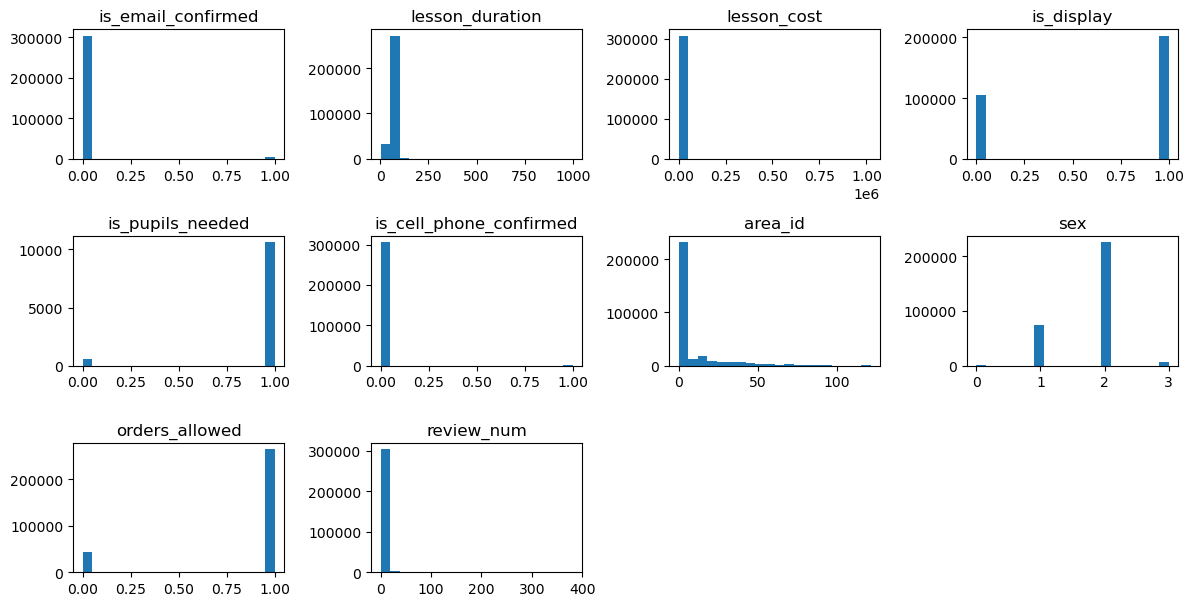

CPU times: user 1.64 s, sys: 22.5 ms, total: 1.66 s
Wall time: 1.09 s


In [23]:
%%time
fig = plt.figure(figsize=(12, 8))

ax_list = []

#selected_columns = ['is_email_confirmed', 'column2', 'column3', ...]

nrows, ncols = (4, 4)

for i, column in enumerate(selected_columns):
    ax = fig.add_subplot(nrows, ncols, i+1)
    ax.hist(teachers_info[column], bins = 20)
    plt.title(column)

plt.tight_layout()
plt.show()

Интересно. очень много отсюда можно взять. 

Потенциальные параметры : email, телефон, длительность уроков, стоимость уроков, возраст, стаж, пол, количество отзывов, количество времени на сайте. 

 ## Ученики (lesson_course.feather)

In [24]:
lesson_course = pd.read_feather('datasets/lesson_course.feather')

In [25]:
lesson_course

,id,client_id,teacher_id,order_id,lesson_place,lesson_price,is_active,lesson_duration,date_updated,suspend_till_date
0,240884,427831.0,133738,718009.0,2,1000,1,60,2021-04-25 23:08:17.883,2018-08-27 00:00:00.000
1,242243,429075.0,106838,720876.0,1,0,0,0,2021-12-03 23:05:52.873,2020-08-01 00:00:00.000
2,242364,429089.0,14700,720912.0,1,0,0,0,2022-05-25 07:27:15.077,2019-09-08 14:22:41.940
3,242476,428940.0,138783,721219.0,1,0,0,0,2021-06-22 20:36:53.287,2018-09-03 00:00:00.000
4,242942,424704.0,3476,720891.0,4,600,0,60,2021-12-19 13:29:29.257,2022-03-20 00:00:00.000
...,...,...,...,...,...,...,...,...,...,...
893433,1471872,1252133.0,303803,2891331.0,2,700,1,60,2023-10-19 18:01:40.443,1800-01-01 00:00:00.000
893434,1471873,1252235.0,104006,2891600.0,3,1500,0,60,2023-10-17 14:33:55.870,1800-01-01 00:00:00.000
893435,1471874,847887.0,290119,2892571.0,4,1500,0,60,2023-10-17 14:39:33.830,1800-01-01 00:00:00.000
893436,1471875,1251873.0,173857,2890717.0,6,1500,0,60,2023-10-17 14:40:20.520,1800-01-01 00:00:00.000


* Id - айди
* client_id - айди ученика
* teacher_id - айди репетитора
* order_id - айди заявки
* lesson_place - занятия онлайн или офлайн
* lesson_price - цена
* is_active - идут ли занятия, на паузе, завершены
* lesson_duration - продолжительность урока
* date_updated
* suspend_till_date

In [26]:
lesson_course['client_id'].value_counts()

1.0          162
1012593.0    154
810610.0     141
386364.0     101
751267.0      74
            ... 
1049257.0      1
997771.0       1
1053195.0      1
1051824.0      1
1252133.0      1
Name: client_id, Length: 408319, dtype: int64

In [27]:
display(lesson_course[lesson_course['client_id'] == 1012593.0 ])

,id,client_id,teacher_id,order_id,lesson_place,lesson_price,is_active,lesson_duration,date_updated,suspend_till_date
332454,1126062,1012593.0,170930,2364021.0,4,1000,1,60,2022-12-12 13:09:37.833,1800-01-01 00:00:00.000
351791,1127888,1012593.0,253917,2367438.0,4,1500,1,60,2022-12-15 19:48:09.433,1800-01-01 00:00:00.000
351813,1127910,1012593.0,175783,2367453.0,4,1800,0,60,2022-12-11 13:33:02.390,1800-01-01 00:00:00.000
351834,1127931,1012593.0,218906,2367500.0,4,0,1,60,2022-12-13 17:03:48.287,1800-01-01 00:00:00.000
351842,1127939,1012593.0,125776,2367511.0,4,1800,0,60,2022-12-11 13:47:21.553,1800-01-01 00:00:00.000
...,...,...,...,...,...,...,...,...,...,...
773216,1352634,1012593.0,271728,2709680.0,4,1500,0,60,2023-08-16 09:56:37.393,1800-01-01 00:00:00.000
773222,1352640,1012593.0,113814,2710377.0,4,1500,0,60,2023-08-16 10:56:30.783,1800-01-01 00:00:00.000
773225,1352643,1012593.0,122907,2710386.0,4,1500,0,60,2023-08-16 10:59:47.117,1800-01-01 00:00:00.000
781094,1334754,1012593.0,212814,2683536.0,4,1500,0,60,2023-07-28 20:53:32.387,1800-01-01 00:00:00.000


Хорошо, что мы хотя бы знаем, про что эта таблица. А таблица эта отражает, с какими учителями ученик занимался. И что важно, даже не показывает, сколько раз он с ним занимался.

In [28]:
lesson_course.describe()

,id,client_id,teacher_id,order_id,lesson_place,lesson_price,is_active,lesson_duration
count,8.934380e+05,8.934370e+05,893438.000000,8.901320e+05,893438.000000,8.934380e+05,893438.000000,8.934380e+05
mean,1.052919e+06,9.104992e+05,156999.072977,2.201949e+06,3.399830,1.284200e+03,0.222249,-4.737214e+03
std,2.599766e+05,2.360247e+05,79431.722496,4.524514e+05,1.554386,3.624318e+03,0.415758,3.213024e+06
min,1.000000e+01,1.000000e+00,33.000000,1.100000e+01,0.000000,0.000000e+00,0.000000,-2.147484e+09
25%,8.303462e+05,7.685850e+05,95659.000000,1.808246e+06,2.000000,7.000000e+02,0.000000,6.000000e+01
50%,1.053760e+06,9.266170e+05,160006.000000,2.219964e+06,4.000000,1.000000e+03,0.000000,6.000000e+01
75%,1.277182e+06,1.107521e+06,220809.000000,2.602854e+06,4.000000,1.500000e+03,0.000000,6.000000e+01
max,1.505419e+06,1.268616e+06,312244.000000,2.936670e+06,7.000000,2.500000e+06,1.000000,8.032022e+06


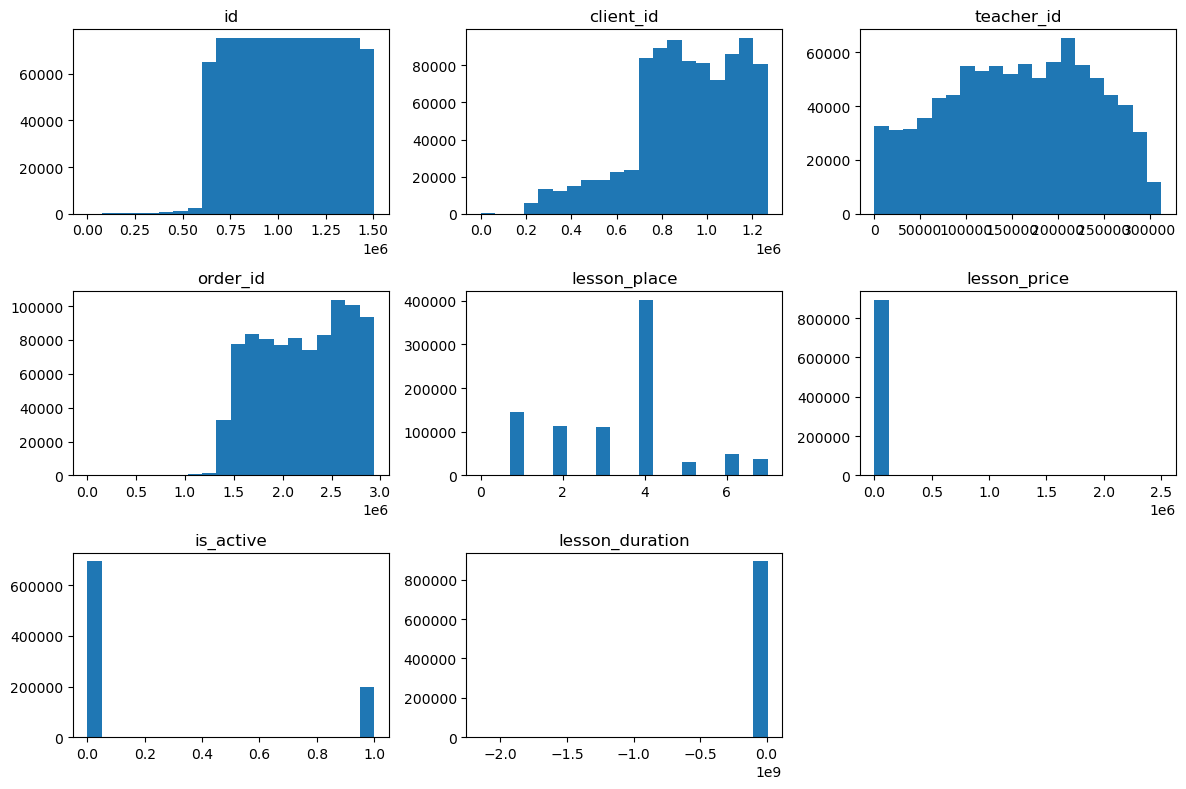

In [29]:
fig = plt.figure(figsize=(12, 8))

ax_list = []

nrows, ncols = (3, 3)

for i, column in enumerate(lesson_course.columns.drop(['date_updated', 'suspend_till_date'])):
    ax = fig.add_subplot(nrows, ncols, i+1)
    ax.hist(lesson_course[column], bins = 20)
    plt.title(column)

plt.tight_layout()
plt.show()

Из того, что я вижу, эта таблица не сможет нам много дать хотя бы просто потому, что агрегировнные показатели из нее уже включены в целевую таблицу teachers. Лучше давайте подумаем, что еще отсюда можно взять. 

- место проведения (либо конкретная цифра, либо микс) 
- я бы посмотрел долю актвных учеников (но мне кажется, это просто ухудшит показатели опытных учителей и все. Но как вариант можно на год размазать. 
- Хотя в целях исследования я бы, наоборот, классфицировал учеников и смотрел бы, какая у ученика доля активности по преподавателям... Но проблема этого в том, что оно не улучшит наше качество прогноза а будет иметь только пользу в и сследовательнском смысле поэтому спешить с этим не буду. Но ученик ученику рознь и это факт. Тот, кто хочет заниматься, будет заниматься с куда болььешй вероятностью с другим репетитором, если понадобится. В общем, проблема эта комплексная и я пока оставлю вопрос откртытым. 

## Занятия (lessons.feather)

In [30]:
lessons = pd.read_feather('datasets/lessons.feather')

In [31]:
lessons

,id,lesson_course_id,lesson_date,time_from,time_to,home_task,is_regular,amount_to_pay,amount_paid
0,135797,347,2023-04-14 00:00:00.000,12:45:00,13:50:00,NaN,1,NaN,NaN
1,283596,185756,2022-11-15 00:00:00.000,20:30:00,21:30:00,NaN,0,NaN,NaN
2,322184,184189,2022-12-15 00:00:00.000,16:00:00,17:30:00,NaN,0,NaN,NaN
3,371621,213849,2023-02-13 00:00:00.000,19:30:00,20:30:00,NaN,0,NaN,NaN
4,375586,196475,2023-02-16 00:00:00.000,10:00:00,11:00:00,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1191122,4516915,1465794,2023-12-25 00:00:00.000,20:00:00,21:00:00,NaN,0,NaN,NaN
1191123,4516919,1465794,2024-01-22 00:00:00.000,20:00:00,21:00:00,NaN,0,NaN,NaN
1191124,4516920,1465794,2024-01-29 00:00:00.000,20:00:00,21:00:00,NaN,0,NaN,NaN
1191125,4516940,1525472,2024-02-01 00:00:00.000,12:30:00,13:30:00,NaN,0,NaN,NaN


* Id - айди
* lesson_course_id - айди ученика
* lesson_date - дата
* time_from - время от 
* time_to - время до
* home_task - дз
* is_regular - автоматически повторяющееся занятие
* amount_to_pay - стоимость
* amount_paid - оплачено

In [32]:
display(lessons['lesson_course_id'].value_counts())

559736     3624
83605      2621
681196      819
1097481     713
714543      595
           ... 
1074647       1
1014541       1
847244        1
847631        1
1610605       1
Name: lesson_course_id, Length: 203876, dtype: int64

In [33]:
lessons.describe()

,id,lesson_course_id,is_regular,amount_to_pay,amount_paid
count,1.191127e+06,1.191127e+06,1.191127e+06,5.933760e+05,8143.000000
mean,2.924256e+06,9.922974e+05,1.695839e-01,1.183844e+03,1817.346801
std,7.860067e+05,2.711573e+05,3.752670e-01,4.684526e+03,972.736517
min,1.357970e+05,3.000000e+00,0.000000e+00,0.000000e+00,200.000000
25%,2.238784e+06,8.177580e+05,0.000000e+00,7.000000e+02,1100.000000
50%,2.891741e+06,9.833430e+05,0.000000e+00,1.000000e+03,1500.000000
75%,3.546280e+06,1.157515e+06,0.000000e+00,1.500000e+03,2000.000000
max,4.516941e+06,1.610713e+06,1.000000e+00,2.500000e+06,24000.000000


%%time
fig = plt.figure(figsize=(12, 8))

ax_list = []


nrows, ncols = (3, 3)

for i, column in enumerate(lessons.columns.drop(['id', 'lesson_date', 'time_from', 'time_to'])):
    ax = fig.add_subplot(nrows, ncols, i+1)
    ax.hist(lessons[column], bins = 20)
    plt.title(column)

plt.tight_layout()
plt.show()

Хотел начартить и тут гистограммы и понял, что нечего тут чертить. И платежная информация - тоже ни о чем - 8000 значений из миллиона... Из выводов: 
- вот где можно взять количество уроков на каждого ученика. 
- А еще можно взять среднее количество уроков на каждого ученика.
- А также долю регулярных занятий

## Цены на занятия репетиторов (teacher_prices.feather)

In [34]:
teacher_prices = pd.read_feather('datasets/teacher_prices.feather')

In [35]:
teacher_prices

,date_update,teacher_id,subject_id,price,price_external,price_remote
0,2008-01-20 19:47:18.587,300.0,2,1200,1200,1200
1,2008-01-22 00:33:39.660,125.0,13,0,0,3000
2,2008-01-22 00:33:39.660,125.0,14,0,0,3000
3,2008-01-22 00:37:01.963,91.0,8,2000,0,0
4,2008-02-08 21:27:19.177,372.0,33,400,400,400
...,...,...,...,...,...,...
432417,2024-01-25 13:07:43.610,317929.0,13,0,500,500
432418,2024-01-25 13:07:43.627,317929.0,14,0,500,500
432419,2024-01-25 13:09:53.387,317928.0,19,0,1500,1200
432420,2024-01-25 13:16:36.447,317927.0,2,0,0,800


* date_update - дата обновления цен
* teacher_id - айди репетитора
* subject_id - айди предмета
* price - цена занятий у себя
* price_external - цена занятий на выезде
* price_remote - цена онлайн занятий

In [36]:
teacher_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432422 entries, 0 to 432421
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date_update     432422 non-null  object 
 1   teacher_id      427852 non-null  float64
 2   subject_id      432422 non-null  int64  
 3   price           432422 non-null  int64  
 4   price_external  432422 non-null  int64  
 5   price_remote    432422 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 19.8+ MB


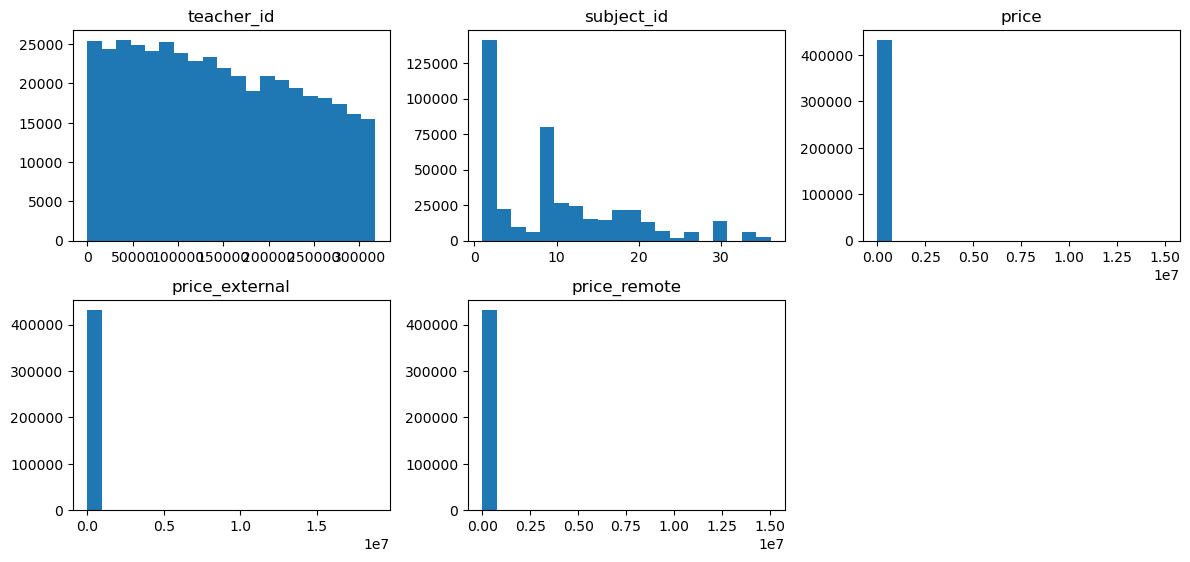

In [37]:
fig = plt.figure(figsize=(12, 8))

ax_list = []

nrows, ncols = (3, 3)

for i, column in enumerate(teacher_prices.columns.drop('date_update')):
    ax = fig.add_subplot(nrows, ncols, i+1)
    ax.hist(teacher_prices[column], bins = 20)
    plt.title(column)

plt.tight_layout()
plt.show()

Тут я пока не готов изобретать ничего. думаю, есть смысл просто единичками отметить преподавателей, которые выставляют цену ниже порога в 500 рубллей для реигионов и 700 рублей для МСК, потому что это подтвержденный признак недобросовестного преподавателя. 

## Заявки (orders.feather)

In [38]:
orders = pd.read_feather('datasets/orders.feather')

In [39]:
orders

,id,order_date,subject_id,purpose,lesson_price,lesson_duration,lesson_place,home_metro_id,add_info,start_date,...,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,estimated_fee,payment_date,is_display_to_teachers
0,2294054,2022-11-01 00:01:38.237,1.0,None,0,60,None,NaN,None,None,...,0,0,18,2294000.0,675960,7.0,NaN,None,None,1
1,2294055,2022-11-01 00:03:11.753,1.0,None,0,60,None,NaN,None,None,...,0,0,18,2294000.0,675960,7.0,NaN,None,None,1
2,2294056,2022-11-01 00:04:01.563,21.0,Разделы: начертательная геометрия.\nКатегория ...,800,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 10:37:02.567,...,0,0,23,NaN,1024439,10.0,NaN,1200,None,1
3,2294057,2022-11-01 00:08:47.237,8.0,Разделы: школьный курс.\nКатегория ученика: ш...,700,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-11-01 00:08:47.437,...,0,0,14,2293804.0,1024340,17.0,NaN,2310,None,1
4,2294058,2022-11-01 00:11:49.417,8.0,None,0,60,None,122.0,None,None,...,0,0,16,NaN,1024440,5.0,NaN,None,None,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437212,2280503,2022-10-24 19:45:30.277,9.0,Разделы: школьный курс.\nКатегория ученика: ...,1000,60,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-10-24 20:17:29.977,...,0,0,23,NaN,824363,NaN,NaN,2650,2022-11-18 00:06:48.273,1
437213,2280504,2022-10-24 19:45:40.713,1.0,Разделы: школьный курс.\nКатегория ученика: ш...,1000,120,None,NaN,Место проведения занятий: дистанционно (наприм...,2022-10-24 20:07:25.370,...,0,0,14,2280289.0,362987,13.0,NaN,2700,None,1
437214,2280505,2022-10-24 19:45:44.477,2.0,Разделы: общий курс.\nКатегория ученика: 1 кла...,600,60,None,489.0,Район: Ленинский район.\nМесто проведения заня...,2022-10-24 20:45:51.357,...,1,0,23,NaN,1019633,17.0,NaN,900,None,1
437215,2280506,2022-10-24 19:46:02.453,18.0,Разделы: математика.\nКатегория ученика: школь...,900,60,None,487.0,Район: Автозаводский район.\nМесто проведения ...,None,...,0,1,14,2200131.0,791697,8.0,NaN,2565,None,1


- order_date - дата создания 
- subject_id - предмет
- purpose - цель занятий
- lesson_price - цена
- lesson_duration - желаемая проодолжительность урока
- home_metro_id - ближайшее метро
- add_info - доп инфо
- start_date
- working_teacher_id
- status_id - оплачена ли заявка (значения 6 и 13 говорят о факте оплаты заявки)
- comments   
- amount_to_pay
- planned_lesson_number - клиент планирует N занятий
- first_lesson_date - дата 1 занятия
- creator_id - кто создал заявку (id сотрудника или клиента)
- pupil_category_new_id - возраст ученика
- lessons_per_week - занятий а неделю
- minimal_price
- teacher_sex - пол репетитора
- teacher_experience_from - опыт репетитора от
- teacher_experience_to- опыт репетитора до
- lesson_place_new - онлайн, у ученика, у учителя
- pupil_knowledgelvl -уровень знаний ученика
- teacher_age_from - желаемый возраст репеитора от
- teacher_age_to - желаемый возраст репеитора от
- chosen_teachers_only - не предлагать репетиторов кроме выбранных самостоятельно
- no_teachers_available - на заявку нет подходящих репов
- source_id - где создана заявка (какая часть сайта, не регион)
- original_order_id - дублем какой заявки является эта заявка
- client_id - айди клиента
- additional_status_id
- max_metro_distance - максимально готов ехать от метро
- estimated_fee 
- payment_date
- test_group - аб тесты
- is_display_to_teachers - хочет ли клиент получать отклики репетиторов

In [40]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1191861 entries, 0 to 437216
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   id                       1191861 non-null  int32  
 1   order_date               1191861 non-null  object 
 2   subject_id               1181529 non-null  float32
 3   purpose                  1025351 non-null  object 
 4   lesson_price             1191861 non-null  int32  
 5   lesson_duration          1191861 non-null  int32  
 6   lesson_place             31 non-null       object 
 7   home_metro_id            642447 non-null   float32
 8   add_info                 1044688 non-null  object 
 9   start_date               705578 non-null   object 
 10  working_teacher_id       705988 non-null   float32
 11  status_id                1191861 non-null  int32  
 12  comments                 341468 non-null   object 
 13  prefered_teacher_id      4 non-null        

In [41]:
orders.describe()

,id,subject_id,lesson_price,lesson_duration,home_metro_id,working_teacher_id,status_id,prefered_teacher_id,planned_lesson_number,creator_id,...,teacher_age_from,teacher_age_to,chosen_teachers_only,no_teachers_available,source_id,original_order_id,client_id,additional_status_id,max_metro_distance,is_display_to_teachers
count,1.191861e+06,1.181529e+06,1.191861e+06,1.191861e+06,6.424470e+05,7.059880e+05,1.191861e+06,4.000000e+00,1.191861e+06,5.796980e+05,...,1.191861e+06,1.191861e+06,1.191861e+06,1.191861e+06,1.191861e+06,582588.000,1.191861e+06,1.042385e+06,1.351800e+04,1.191861e+06
mean,2.340488e+06,2.138735e+01,2.019466e+03,7.186754e+01,8.130288e+02,1.644861e+05,2.436352e+01,3.342593e+06,1.952076e+01,6.682231e+05,...,1.955505e+01,2.863540e+01,2.237090e-02,9.083526e-02,2.877031e+01,2325827.000,9.625180e+05,2.357963e+01,1.388366e+03,9.641678e-01
std,3.445563e+05,6.157319e+03,9.163341e+05,6.130494e+03,8.362938e+03,8.183689e+04,6.130578e+03,1.858466e+05,6.130586e+03,4.012326e+05,...,6.130600e+03,6.131385e+03,1.478866e-01,2.873748e-01,6.130570e+03,348043.875,2.177188e+05,6.555405e+03,7.183886e+04,1.858717e-01
min,1.742636e+06,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.300000e+01,1.000000e+00,3.211265e+06,0.000000e+00,4.500000e+01,...,-4.000000e+01,-1.100000e+02,0.000000e+00,0.000000e+00,0.000000e+00,263.000,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,2.041441e+06,3.000000e+00,5.000000e+02,6.000000e+01,2.280000e+02,1.009130e+05,7.000000e+00,3.211265e+06,1.000000e+01,3.046100e+05,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.400000e+01,2022765.000,8.680830e+05,7.000000e+00,3.000000e+01,1.000000e+00
50%,2.341556e+06,8.000000e+00,1.000000e+03,6.000000e+01,6.440000e+02,1.695160e+05,1.600000e+01,3.276801e+06,1.000000e+01,7.806650e+05,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.600000e+01,2318886.000,9.896330e+05,1.000000e+01,3.000000e+01,1.000000e+00
75%,2.638720e+06,1.300000e+01,1.500000e+03,6.000000e+01,1.146000e+03,2.343302e+05,1.600000e+01,3.408129e+06,1.000000e+01,9.715650e+05,...,2.000000e+01,4.000000e+01,0.000000e+00,0.000000e+00,2.300000e+01,2631660.000,1.125538e+06,1.300000e+01,3.000000e+01,1.000000e+00
max,3.605505e+06,3.605505e+06,1.000000e+09,3.605505e+06,3.605505e+06,3.605505e+06,3.605505e+06,3.605505e+06,3.605505e+06,3.605505e+06,...,3.605505e+06,3.605505e+06,1.000000e+00,1.000000e+00,3.605505e+06,3605505.000,3.605505e+06,3.605505e+06,5.000000e+06,1.000000e+00


Ну а это уже очень страшная таблица. Скорее всего, большинство "красных флагов" берутся как раз-таки отсюда. 

- Статус заявки договорились о занятиях, оплат нет более недели (и не перенесено)
    status в orders = 9
    lessons с amount_payed > 0 за последнюю неделю
- status_id - оплачена ли заявка (значения 6 и 13 говорят о факте оплаты заявки). То есть другой статус означает отсутствие оплаты. 


## План работы

- Более детально смотрим таргет таблицу (чисткой я заниматься не очень хочу просто потому что чистить моммлионы информации чтобы замерджить в полторы тысячи кажется мне неэфективным. И я почти уверен, что у "размеченных репетиторов все будет в порядке"). 
- Смотрим отдельно каждую из вспомогательных таблиц, собираем статистику и важные признаки. (по бОльшей части сделано выше)
- Пытаемся создать группировки и классы. Сравнения со средними и т.д. 
- созданные параметры и классы добавляем в таргет таблицу
- строим новую модель. 

- Поскольку у нас уже есть потенциально интересные для модели параметры под каждой таблицей, можно даже попробовать быстро собрать какую-то простую бэйслайн - модель с кросс-валидацией чтобы посмотреть на важность признаков и, возможно, это даст какие-то идеи. А за одно еще и скор посмотрим. Для этого можно просто замерджить все выбранные параметры в размеченный датасет и построить на этом модель. 

# Создание таблицы признаков

## Teachers_info

Потенциальные параметры : email, телефон, длительность уроков, стоимость уроков, возраст, стаж, пол, количество отзывов, количество времени на сайте.

In [42]:
actual_date = pd.to_datetime('2024-03-01')

In [43]:
teachers_info = teachers_info[teachers_info['id'].isin(teachers['id'])]
teachers_info

,id,reg_date,birth_date,teaching_start_date,is_email_confirmed,lesson_duration,lesson_cost,is_display,last_visited,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num
362,458,2008-02-16,1982-01-03,2000-09-01,0,60,2000,1,2022-04-22,0.0,0,1,2,1,7
894,1009,2008-05-23,1982-04-13,2001-09-01,0,60,1500,1,2022-10-20,1.0,0,1,2,1,26
2343,2536,2008-11-05,1972-09-02,1991-09-01,0,60,2500,1,2022-10-22,0.0,0,1,2,1,85
2585,2791,2008-11-21,1976-02-24,1999-09-01,0,60,1800,1,2022-10-23,0.0,0,1,2,1,35
3372,3619,2009-02-05,1987-06-10,2005-09-01,0,60,1300,1,2022-10-23,0.0,0,1,2,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307450,312101,2023-11-02,2001-01-28,2021-09-01,0,60,0,1,NaT,NaN,0,1,2,1,0
307667,312318,2023-11-04,2003-05-15,2023-09-01,0,60,600,1,NaT,NaN,0,14,1,1,0
307680,312331,2023-11-04,2002-06-25,2018-09-01,0,30,0,1,NaT,NaN,0,52,2,1,0
307760,312411,2023-11-05,1955-11-17,1978-09-01,0,60,0,1,NaT,NaN,0,1,2,1,0


In [44]:
teachers_info['reg_date'] = pd.to_datetime(teachers_info['reg_date'])
teachers_info['birth_date'] = pd.to_datetime(teachers_info['birth_date'])
teachers_info['teaching_start_date'] = pd.to_datetime(teachers_info['teaching_start_date'])
teachers_info['last_visited'] = pd.to_datetime(teachers_info['last_visited'])

In [45]:
teachers_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1602 entries, 362 to 307795
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       1602 non-null   int64         
 1   reg_date                 1602 non-null   datetime64[ns]
 2   birth_date               1602 non-null   datetime64[ns]
 3   teaching_start_date      1602 non-null   datetime64[ns]
 4   is_email_confirmed       1602 non-null   int64         
 5   lesson_duration          1602 non-null   int64         
 6   lesson_cost              1602 non-null   int64         
 7   is_display               1602 non-null   int64         
 8   last_visited             1249 non-null   datetime64[ns]
 9   is_pupils_needed         26 non-null     float64       
 10  is_cell_phone_confirmed  1602 non-null   int64         
 11  area_id                  1602 non-null   int64         
 12  sex                      1602 

In [46]:
teachers_info['age'] = (actual_date - teachers_info['birth_date']).astype('<m8[Y]')

In [47]:
teachers_info['experience'] = (actual_date - teachers_info['teaching_start_date']).astype('<m8[Y]')

In [48]:
teachers_info['years_registered'] = (actual_date - teachers_info['reg_date']).astype('<m8[Y]')

In [49]:
# teachers_info['not_visited'] = (actual_date - teachers_info['last_visited']) / pd.Timedelta(days=30)
# это нам, пожалуй, не надо, слишком много пропусков. 

In [50]:
teachers_info

,id,reg_date,birth_date,teaching_start_date,is_email_confirmed,lesson_duration,lesson_cost,is_display,last_visited,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num,age,experience,years_registered
362,458,2008-02-16,1982-01-03,2000-09-01,0,60,2000,1,2022-04-22,0.0,0,1,2,1,7,42.0,23.0,16.0
894,1009,2008-05-23,1982-04-13,2001-09-01,0,60,1500,1,2022-10-20,1.0,0,1,2,1,26,41.0,22.0,15.0
2343,2536,2008-11-05,1972-09-02,1991-09-01,0,60,2500,1,2022-10-22,0.0,0,1,2,1,85,51.0,32.0,15.0
2585,2791,2008-11-21,1976-02-24,1999-09-01,0,60,1800,1,2022-10-23,0.0,0,1,2,1,35,48.0,24.0,15.0
3372,3619,2009-02-05,1987-06-10,2005-09-01,0,60,1300,1,2022-10-23,0.0,0,1,2,1,3,36.0,18.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307450,312101,2023-11-02,2001-01-28,2021-09-01,0,60,0,1,NaT,NaN,0,1,2,1,0,23.0,2.0,0.0
307667,312318,2023-11-04,2003-05-15,2023-09-01,0,60,600,1,NaT,NaN,0,14,1,1,0,20.0,0.0,0.0
307680,312331,2023-11-04,2002-06-25,2018-09-01,0,30,0,1,NaT,NaN,0,52,2,1,0,21.0,5.0,0.0
307760,312411,2023-11-05,1955-11-17,1978-09-01,0,60,0,1,NaT,NaN,0,1,2,1,0,68.0,45.0,0.0


In [51]:
teachers_info['lesson_cost'].value_counts()

1500    260
1000    245
0       149
2000    148
800      88
1200     84
2500     80
700      72
500      65
600      49
3000     49
900      43
1300     41
1800     38
400      18
1400     17
750      14
1100     14
1700     12
4000     11
5000     11
1600      9
1250      8
650       7
3500      7
300       6
6000      4
1900      4
550       4
350       4
450       4
2300      3
2700      3
3750      2
2600      2
990       2
2200      2
2400      2
4500      1
1490      1
2190      1
950       1
1178      1
4800      1
1950      1
1150      1
850       1
3200      1
1350      1
1125      1
2250      1
2800      1
2380      1
625       1
5500      1
2100      1
250       1
1850      1
1002      1
Name: lesson_cost, dtype: int64

Хорошо, нолей всего 149 - с этим можно жить. пускай ноль будет нулем. Можно даже сделать отдельную категори, если что. 

In [52]:
#for i in teachers_info
#if teachers_info[i]['lesson_cost'] teachers_info['low_price'] = 
def find_low_price(row):
    if row['lesson_cost'] == 0:
        return 0
    elif (row['lesson_cost'] < 500) and (row['area_id'] != 1):
        return 1
    elif (row['lesson_cost'] < 700) and (row['area_id'] == 1):
        return 1
    else:
        return 2

In [53]:
teachers_info['low_price'] = teachers_info.apply(find_low_price, axis = 1)

In [54]:
teachers_info

,id,reg_date,birth_date,teaching_start_date,is_email_confirmed,lesson_duration,lesson_cost,is_display,last_visited,is_pupils_needed,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num,age,experience,years_registered,low_price
362,458,2008-02-16,1982-01-03,2000-09-01,0,60,2000,1,2022-04-22,0.0,0,1,2,1,7,42.0,23.0,16.0,2
894,1009,2008-05-23,1982-04-13,2001-09-01,0,60,1500,1,2022-10-20,1.0,0,1,2,1,26,41.0,22.0,15.0,2
2343,2536,2008-11-05,1972-09-02,1991-09-01,0,60,2500,1,2022-10-22,0.0,0,1,2,1,85,51.0,32.0,15.0,2
2585,2791,2008-11-21,1976-02-24,1999-09-01,0,60,1800,1,2022-10-23,0.0,0,1,2,1,35,48.0,24.0,15.0,2
3372,3619,2009-02-05,1987-06-10,2005-09-01,0,60,1300,1,2022-10-23,0.0,0,1,2,1,3,36.0,18.0,15.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307450,312101,2023-11-02,2001-01-28,2021-09-01,0,60,0,1,NaT,NaN,0,1,2,1,0,23.0,2.0,0.0,0
307667,312318,2023-11-04,2003-05-15,2023-09-01,0,60,600,1,NaT,NaN,0,14,1,1,0,20.0,0.0,0.0,2
307680,312331,2023-11-04,2002-06-25,2018-09-01,0,30,0,1,NaT,NaN,0,52,2,1,0,21.0,5.0,0.0,0
307760,312411,2023-11-05,1955-11-17,1978-09-01,0,60,0,1,NaT,NaN,0,1,2,1,0,68.0,45.0,0.0,0


email, телефон, длительность уроков, стоимость уроков, возраст, стаж, пол, количество отзывов, количество времени на сайте.

In [55]:
t_info = teachers_info[['id', 'is_email_confirmed', 'lesson_duration',
                       'lesson_cost', 'is_display', 'is_cell_phone_confirmed', 
                       'area_id', 'sex', 'orders_allowed', 'review_num',
                       'age', 'experience', 'years_registered',
                       'low_price']]

In [56]:
t_info

,id,is_email_confirmed,lesson_duration,lesson_cost,is_display,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num,age,experience,years_registered,low_price
362,458,0,60,2000,1,0,1,2,1,7,42.0,23.0,16.0,2
894,1009,0,60,1500,1,0,1,2,1,26,41.0,22.0,15.0,2
2343,2536,0,60,2500,1,0,1,2,1,85,51.0,32.0,15.0,2
2585,2791,0,60,1800,1,0,1,2,1,35,48.0,24.0,15.0,2
3372,3619,0,60,1300,1,0,1,2,1,3,36.0,18.0,15.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307450,312101,0,60,0,1,0,1,2,1,0,23.0,2.0,0.0,0
307667,312318,0,60,600,1,0,14,1,1,0,20.0,0.0,0.0,2
307680,312331,0,30,0,1,0,52,2,1,0,21.0,5.0,0.0,0
307760,312411,0,60,0,1,0,1,2,1,0,68.0,45.0,0.0,0


In [57]:
teachers

,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked
0,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0
1,153845,1111.0,884.085028,1082.0,0.358974,77.285714,956580.0,0
2,42869,505.0,2500.000000,184.0,0.142857,61.333333,460000.0,0
3,127280,442.0,1879.338843,363.0,0.150000,60.500000,682200.0,0
4,283905,694.0,1252.434457,534.0,0.257143,59.333333,668800.0,0
...,...,...,...,...,...,...,...,...
1651,294498,1.0,1500.000000,1.0,0.166667,1.000000,1500.0,0
1652,3619,1.0,1300.000000,1.0,0.111111,1.000000,1300.0,0
1653,238509,4.0,900.000000,1.0,0.071429,1.000000,900.0,1
1654,180353,1.0,1700.000000,1.0,0.100000,1.000000,1700.0,0


In [58]:
teachers = pd.merge(teachers, t_info, on='id', how='inner')

In [59]:
teachers

,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked,is_email_confirmed,lesson_duration,...,is_display,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num,age,experience,years_registered,low_price
0,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0,0,60,...,1,0,2,1,1,10,26.0,6.0,3.0,2
1,153845,1111.0,884.085028,1082.0,0.358974,77.285714,956580.0,0,0,60,...,1,0,13,2,1,26,55.0,38.0,5.0,2
2,42869,505.0,2500.000000,184.0,0.142857,61.333333,460000.0,0,0,60,...,1,0,2,2,1,64,58.0,21.0,11.0,2
3,127280,442.0,1879.338843,363.0,0.150000,60.500000,682200.0,0,0,60,...,1,0,1,2,1,10,37.0,18.0,6.0,2
4,283905,694.0,1252.434457,534.0,0.257143,59.333333,668800.0,0,0,45,...,1,0,116,2,1,1,50.0,31.0,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1597,294498,1.0,1500.000000,1.0,0.166667,1.000000,1500.0,0,0,60,...,0,0,38,2,1,1,27.0,6.0,0.0,2
1598,3619,1.0,1300.000000,1.0,0.111111,1.000000,1300.0,0,0,60,...,1,0,1,2,1,3,36.0,18.0,15.0,2
1599,238509,4.0,900.000000,1.0,0.071429,1.000000,900.0,1,0,60,...,1,0,6,2,0,4,28.0,6.0,2.0,2
1600,180353,1.0,1700.000000,1.0,0.100000,1.000000,1700.0,0,0,60,...,1,0,2,2,1,11,47.0,8.0,4.0,2


Хорошо. идем дальше. 

## Lesson_coures

In [60]:
lesson_course

,id,client_id,teacher_id,order_id,lesson_place,lesson_price,is_active,lesson_duration,date_updated,suspend_till_date
0,240884,427831.0,133738,718009.0,2,1000,1,60,2021-04-25 23:08:17.883,2018-08-27 00:00:00.000
1,242243,429075.0,106838,720876.0,1,0,0,0,2021-12-03 23:05:52.873,2020-08-01 00:00:00.000
2,242364,429089.0,14700,720912.0,1,0,0,0,2022-05-25 07:27:15.077,2019-09-08 14:22:41.940
3,242476,428940.0,138783,721219.0,1,0,0,0,2021-06-22 20:36:53.287,2018-09-03 00:00:00.000
4,242942,424704.0,3476,720891.0,4,600,0,60,2021-12-19 13:29:29.257,2022-03-20 00:00:00.000
...,...,...,...,...,...,...,...,...,...,...
893433,1471872,1252133.0,303803,2891331.0,2,700,1,60,2023-10-19 18:01:40.443,1800-01-01 00:00:00.000
893434,1471873,1252235.0,104006,2891600.0,3,1500,0,60,2023-10-17 14:33:55.870,1800-01-01 00:00:00.000
893435,1471874,847887.0,290119,2892571.0,4,1500,0,60,2023-10-17 14:39:33.830,1800-01-01 00:00:00.000
893436,1471875,1251873.0,173857,2890717.0,6,1500,0,60,2023-10-17 14:40:20.520,1800-01-01 00:00:00.000


In [61]:
lesson_course.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893438 entries, 0 to 893437
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 893438 non-null  int64  
 1   client_id          893437 non-null  float64
 2   teacher_id         893438 non-null  int64  
 3   order_id           890132 non-null  float64
 4   lesson_place       893438 non-null  int64  
 5   lesson_price       893438 non-null  int64  
 6   is_active          893438 non-null  int64  
 7   lesson_duration    893438 non-null  int64  
 8   date_updated       893438 non-null  object 
 9   suspend_till_date  893438 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 68.2+ MB


место проведения (либо конкретная цифра, либо микс)

def place_classification(identifier):
    if lesson_course[lesson_course['teacher_id'] == identifier]['lesson_place'].nunique() > 1:
        return 'mix'
    else:
        return lesson_course[lesson_course['teacher_id'] == identifier]['lesson_place'].unique()

In [62]:
#teachers['place_type'] = teachers['id'].apply(place_classification)

In [63]:
#teachers

In [64]:
#teachers['place_type'].value_counts()

Идея, может быть, была и неплохая, но все уперлось в то, что либо везде получается микс, либо пропуски, так что большого смысла не вижу. Параметр нерабочий или как минимум не вычленяется адекватно из предоставленных данных. 

Но кое для чего эта таблица все-таки пригодится

In [65]:
lesson_course = lesson_course[lesson_course['teacher_id'].isin(teachers['id'])]

In [66]:
lesson_course

,id,client_id,teacher_id,order_id,lesson_place,lesson_price,is_active,lesson_duration,date_updated,suspend_till_date
17,248510,433845.0,125321,732085.0,3,0,0,0,2022-09-04 07:55:42.050,2022-09-03 07:55:42.033
31,253119,437361.0,121030,740287.0,3,750,1,60,2020-09-11 20:32:19.287,2018-09-05 00:00:00.000
40,256179,320453.0,42869,745659.0,1,0,0,0,2021-09-08 15:33:01.443,2021-09-07 15:33:01.410
53,260355,442963.0,134603,753155.0,1,1200,0,90,2021-05-29 17:17:55.333,1800-01-01 00:00:00.000
56,261587,444021.0,105295,755552.0,2,400,1,60,2022-02-18 13:50:02.937,1800-01-01 00:00:00.000
...,...,...,...,...,...,...,...,...,...,...
893405,1471844,1251828.0,139998,2890590.0,4,5000,0,60,2023-10-17 14:31:47.270,1800-01-01 00:00:00.000
893410,1471849,1245866.0,280047,2878838.0,4,500,0,60,2023-10-17 14:32:57.077,1800-01-01 00:00:00.000
893419,1471858,1252560.0,162207,2892503.0,4,5000,0,60,2023-10-17 14:36:03.047,1800-01-01 00:00:00.000
893420,1471859,1251387.0,290577,2889303.0,6,900,0,60,2023-10-17 14:33:34.587,1800-01-01 00:00:00.000


In [67]:
lc = lesson_course[['id', 'teacher_id']]

## Lessons

среднее количество уроков на каждого ученика/
доля регулярных занятий

In [68]:
lessons = pd.merge(lessons, lc, left_on= 'lesson_course_id', right_on = 'id', how='inner')

In [69]:
lessons

,id_x,lesson_course_id,lesson_date,time_from,time_to,home_task,is_regular,amount_to_pay,amount_paid,id_y,teacher_id
0,1185299,404816,2022-02-06 00:00:00.000,11:00:00,12:00:00,NaN,0,NaN,NaN,404816,143227
1,2248202,404816,2022-04-24 00:00:00.000,14:00:00,15:00:00,NaN,0,NaN,NaN,404816,143227
2,2453569,404816,2022-09-25 00:00:00.000,14:00:00,15:00:00,NaN,0,NaN,NaN,404816,143227
3,2842374,404816,2023-03-05 00:00:00.000,13:00:00,14:00:00,NaN,0,NaN,NaN,404816,143227
4,3424110,404816,2023-05-07 00:00:00.000,12:00:00,13:00:00,NaN,0,NaN,NaN,404816,143227
...,...,...,...,...,...,...,...,...,...,...,...
294358,4426288,1469075,2024-01-12 00:00:00.000,18:30:00,19:30:00,NaN,0,700.0,NaN,1469075,252757
294359,4449350,1411735,2023-09-30 00:00:00.000,10:00:00,11:00:00,NaN,0,1800.0,NaN,1411735,77256
294360,4449359,1411735,2023-10-08 00:00:00.000,10:00:00,11:00:00,NaN,0,1800.0,NaN,1411735,77256
294361,4449653,1411735,2023-10-22 00:00:00.000,10:00:00,11:00:00,NaN,0,1800.0,NaN,1411735,77256


Прекрасно, теперь у нас только нужные учителя в датасете и возможность идентифицировать этих учителей, а следовательно, найти долю регулярных занятий. 

In [70]:
regular_fraction = lessons.groupby('teacher_id')['is_regular'].mean()

In [71]:
regular_fraction

teacher_id
458       0.000000
1009      0.064000
2536      0.000000
2791      0.000554
3619      0.000000
            ...   
310297    0.000000
310565    0.000000
310973    0.000000
311110    0.000000
311168    0.000000
Name: is_regular, Length: 1524, dtype: float64

In [72]:
regular_fraction.mean()

0.03334475992143021

In [73]:
regular_fraction_df = regular_fraction.reset_index()
regular_fraction_df.columns = ['id', 'regular_fraction']

In [74]:
regular_fraction_df

,id,regular_fraction
0,458,0.000000
1,1009,0.064000
2,2536,0.000000
3,2791,0.000554
4,3619,0.000000
...,...,...
1519,310297,0.000000
1520,310565,0.000000
1521,310973,0.000000
1522,311110,0.000000


In [75]:
teachers = pd.merge(teachers, regular_fraction_df, on = 'id', how='inner')

In [76]:
teachers

,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked,is_email_confirmed,lesson_duration,...,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num,age,experience,years_registered,low_price,regular_fraction
0,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0,0,60,...,0,2,1,1,10,26.0,6.0,3.0,2,0.000000
1,153845,1111.0,884.085028,1082.0,0.358974,77.285714,956580.0,0,0,60,...,0,13,2,1,26,55.0,38.0,5.0,2,0.474293
2,42869,505.0,2500.000000,184.0,0.142857,61.333333,460000.0,0,0,60,...,0,2,2,1,64,58.0,21.0,11.0,2,0.015924
3,127280,442.0,1879.338843,363.0,0.150000,60.500000,682200.0,0,0,60,...,0,1,2,1,10,37.0,18.0,6.0,2,0.001070
4,283905,694.0,1252.434457,534.0,0.257143,59.333333,668800.0,0,0,45,...,0,116,2,1,1,50.0,31.0,1.0,2,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1519,294498,1.0,1500.000000,1.0,0.166667,1.000000,1500.0,0,0,60,...,0,38,2,1,1,27.0,6.0,0.0,2,0.000000
1520,3619,1.0,1300.000000,1.0,0.111111,1.000000,1300.0,0,0,60,...,0,1,2,1,3,36.0,18.0,15.0,2,0.000000
1521,238509,4.0,900.000000,1.0,0.071429,1.000000,900.0,1,0,60,...,0,6,2,0,4,28.0,6.0,2.0,2,0.000000
1522,180353,1.0,1700.000000,1.0,0.100000,1.000000,1700.0,0,0,60,...,0,2,2,1,11,47.0,8.0,4.0,2,0.117647


# Baseline модель

## preparing data

Здесь мы просто соберем даныне в кучу и закодируем категориальные признаки. 

In [77]:
data = teachers

In [78]:
cat_cols = ['is_email_confirmed',
            'lesson_duration', 'is_display', 'is_cell_phone_confirmed',
           'area_id', 'sex', 'orders_allowed', 'low_price']

In [79]:
encoder = OrdinalEncoder()
data[cat_cols] = encoder.fit_transform(data[cat_cols])

In [80]:
data

,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked,is_email_confirmed,lesson_duration,...,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num,age,experience,years_registered,low_price,regular_fraction
0,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0,0.0,5.0,...,0.0,1.0,0.0,1.0,10,26.0,6.0,3.0,2.0,0.000000
1,153845,1111.0,884.085028,1082.0,0.358974,77.285714,956580.0,0,0.0,5.0,...,0.0,12.0,1.0,1.0,26,55.0,38.0,5.0,2.0,0.474293
2,42869,505.0,2500.000000,184.0,0.142857,61.333333,460000.0,0,0.0,5.0,...,0.0,1.0,1.0,1.0,64,58.0,21.0,11.0,2.0,0.015924
3,127280,442.0,1879.338843,363.0,0.150000,60.500000,682200.0,0,0.0,5.0,...,0.0,0.0,1.0,1.0,10,37.0,18.0,6.0,2.0,0.001070
4,283905,694.0,1252.434457,534.0,0.257143,59.333333,668800.0,0,0.0,2.0,...,0.0,61.0,1.0,1.0,1,50.0,31.0,1.0,2.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1519,294498,1.0,1500.000000,1.0,0.166667,1.000000,1500.0,0,0.0,5.0,...,0.0,35.0,1.0,1.0,1,27.0,6.0,0.0,2.0,0.000000
1520,3619,1.0,1300.000000,1.0,0.111111,1.000000,1300.0,0,0.0,5.0,...,0.0,0.0,1.0,1.0,3,36.0,18.0,15.0,2.0,0.000000
1521,238509,4.0,900.000000,1.0,0.071429,1.000000,900.0,1,0.0,5.0,...,0.0,5.0,1.0,0.0,4,28.0,6.0,2.0,2.0,0.000000
1522,180353,1.0,1700.000000,1.0,0.100000,1.000000,1700.0,0,0.0,5.0,...,0.0,1.0,1.0,1.0,11,47.0,8.0,4.0,2.0,0.117647


In [104]:
X = data.drop(['id', 'blocked'], axis = 1)

In [105]:
y = data['blocked']

## building model

А теперь мы просто построим легкую модель при помощи RandomForestClassifier и cross_val_score. 

In [106]:
rf_classifier = RandomForestClassifier(n_estimators=50, max_depth=8, criterion = 'log_loss')

In [107]:
f1_scorer = make_scorer(f1_score, average='micro')

In [108]:
cv_scores = cross_val_score(rf_classifier, X, y, cv=5, scoring=f1_scorer)

In [109]:
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())

Cross-validation scores: [0.63934426 0.6        0.54098361 0.24590164 0.36184211]
Mean cross-validation score: 0.4776143226919759


In [110]:
rf_classifier.fit(X, y)
feature_importances = rf_classifier.feature_importances_

print("Feature Importances:", feature_importances)

Feature Importances: [0.08103447 0.07448848 0.07572078 0.14974994 0.14543891 0.09450643
 0.00165022 0.00755201 0.04175247 0.00164721 0.00101958 0.02651037
 0.00930069 0.06971734 0.04214141 0.03840807 0.03486045 0.02975713
 0.01040438 0.01927957 0.04506009]


In [111]:
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df_sorted = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df_sorted)

                     Feature  Importance
3   lessons_started_fraction    0.149750
4          lessons_per_pupil    0.145439
5             money_recieved    0.094506
0          lessons_delivered    0.081034
2              lessons_given    0.075721
1          mean_lesson_price    0.074488
13            orders_allowed    0.069717
20          different_prices    0.045060
14                review_num    0.042141
8                lesson_cost    0.041752
15                       age    0.038408
16                experience    0.034860
17          years_registered    0.029757
11                   area_id    0.026510
19          regular_fraction    0.019280
18                 low_price    0.010404
12                       sex    0.009301
7            lesson_duration    0.007552
6         is_email_confirmed    0.001650
9                 is_display    0.001647
10   is_cell_phone_confirmed    0.001020


Качество отвратительное. Можно, конечно, модель другую выбрать, можно гиперпараметры покрутить, но это все не даст нам приемлегого результата. Поэтому возвращаемся к данным и ищем дополнительные фичи.

Теперь я хочу прояснить одну очень важную вещь. Наши данные неполные. У нас размечены только те, кого поймали и те, кто подходит по параметрам, которые уже указаны. А еще у нас очень неправильная разметка. Я считаю, что отдельно надо делать мошенников, а неэффективных преподавателей отдельно. Тогда у моделей будет выше точность и все зависимости тоже будут отображаться более четко. 

Ну а раз вся разметка сводится тупо к парметрам, указанным в тз, то есть смысл просто добавить их, вот и все. На них была основана текущая разметка - стало быть они и дадут прирост качества метрики.

## Catboost

Все-таки решил я запустить Catboost модель - уж слишком мне не нравится метрика и не очень верится, что данные могут быть настолько плохими. Кроме того хочется сравнить свои метрики с метриками другиих уычастников. 

In [112]:
data_pool = Pool(data=X, label=y)

In [90]:
#cat = CatBoostClassifier(
#    iterations=100,
 #   learning_rate=0.1,
  #  l2_leaf_reg=0.1,
   # verbose=False
#)

In [91]:
#param_grid = {
 #   'learning_rate': [0.1, 0.01, 0.001],
  #  'depth': [4, 6, 8],
   # 'iterations': [100, 200, 300],
    #'l2_leaf_reg': [0.1, 0.5, 1, 10],
#}

In [113]:
catboost_params = {
    #'iterations': 1000,
    'iterations': 100,
    'learning_rate': 0.1,
    'depth': 6,
    'loss_function': 'Logloss',
    'eval_metric': 'F1',
    'verbose': 100
}

In [114]:
cv_results = cv(pool=data_pool, params=catboost_params, fold_count=5, stratified=True)

Training on fold [0/5]
0:	learn: 0.6423358	test: 0.5700000	best: 0.5700000 (0)	total: 4.57ms	remaining: 452ms


99:	learn: 0.9013080	test: 0.6372549	best: 0.6403941 (88)	total: 444ms	remaining: 0us

bestTest = 0.6403940887
bestIteration = 88

Training on fold [1/5]
0:	learn: 0.6028097	test: 0.6054054	best: 0.6054054 (0)	total: 6.8ms	remaining: 674ms
99:	learn: 0.8880952	test: 0.6960784	best: 0.7029703 (93)	total: 448ms	remaining: 0us

bestTest = 0.702970297
bestIteration = 93

Training on fold [2/5]
0:	learn: 0.6104218	test: 0.5410628	best: 0.5410628 (0)	total: 4.16ms	remaining: 412ms
99:	learn: 0.9047619	test: 0.6666667	best: 0.6849315 (89)	total: 418ms	remaining: 0us

bestTest = 0.6849315068
bestIteration = 89

Training on fold [3/5]
0:	learn: 0.6651323	test: 0.5446009	best: 0.5446009 (0)	total: 5.09ms	remaining: 504ms
99:	learn: 0.8931116	test: 0.5940594	best: 0.6300000 (6)	total: 436ms	remaining: 0us

bestTest = 0.63
bestIteration = 6

Training on fold [4/5]
0:	learn: 0.6060606	test: 0.5674419	best: 0.5674419 (0)	total: 3.86ms	remaining: 382ms
99:	learn: 0.8928571	test: 0.6448598	best: 0.663

In [94]:
#start_time = time.time()
#grid_search = GridSearchCV(estimator=cat, param_grid=param_grid, cv=5)
#grid_search.fit(x_train, y_train)
#end_time = time.time()
#print('Execution time:', end_time - start_time, 'seconds')

In [95]:
#print("Best Hyperparameters:", grid_search.best_params_)

In [96]:
#best_model.fit(x_train, y_train)

In [115]:
print(cv_results)

    iterations  test-F1-mean  test-F1-std  train-F1-mean  train-F1-std  \
0            0      0.565702     0.025740       0.625352      0.027268   
1            1      0.593743     0.020484       0.647700      0.025064   
2            2      0.584824     0.014341       0.653168      0.013737   
3            3      0.582001     0.024682       0.651156      0.015551   
4            4      0.591233     0.023462       0.661175      0.015969   
..         ...           ...          ...            ...           ...   
95          95      0.648274     0.041534       0.888842      0.004858   
96          96      0.648582     0.038036       0.890323      0.006306   
97          97      0.648425     0.040570       0.891646      0.006521   
98          98      0.649066     0.041413       0.894291      0.005287   
99          99      0.647784     0.037731       0.896027      0.006813   

    test-Logloss-mean  test-Logloss-std  train-Logloss-mean  train-Logloss-std  
0            0.658478         

Из хорошего - достаточно 100 итераций и качетво модели растет невероятно быстро. Я рад, что не надо слишком много итераций - и без того очень велик риск переобучения. 

Давайте тоже взглянем на значения параметров и хотя бы примерно сравним с лесом.

In [116]:
catboost_model = CatBoostClassifier(**catboost_params)
catboost_model.fit(X, y)
feature_importances = catboost_model.get_feature_importance()

0:	learn: 0.6516854	total: 1.56ms	remaining: 155ms
99:	learn: 0.8662175	total: 181ms	remaining: 0us


In [117]:
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False)
for index, row in importance_df.iterrows():
    print(f"{row['Feature']}: {row['Importance']}")


lessons_started_fraction: 15.522391611467336
lessons_per_pupil: 13.54990125312444
orders_allowed: 8.214328483497834
mean_lesson_price: 7.141532189854132
money_recieved: 6.483330309182534
lessons_given: 5.979160748031766
lessons_delivered: 5.198309371296709
lesson_cost: 4.920631146362838
different_prices: 4.704091421715501
years_registered: 4.480375364410841
age: 4.037232688852622
review_num: 3.9104249639708697
regular_fraction: 3.681005969195809
experience: 3.5352275738380743
area_id: 3.242474881221912
low_price: 2.36095832418088
sex: 1.549318065216577
lesson_duration: 1.074255099260948
is_email_confirmed: 0.24353557995381273
is_cell_phone_confirmed: 0.1485495888742987
is_display: 0.022965366490284876


# Добавляем параметры из ТЗ

Список параметров, которые мы можем добавить 
- [x] Низакая цена (<500руб регионы и ≤700руб МСК) [x]
- [x] Разная стоимость с одним или разными учениками [x]
- Часто или редко заходит в приложение
- Оплаты по разным ученикам рядом по времени
- Оплат нет, а статус ученика "незавершенынй" или "договорились"
- Занятие проведено,а оплат нет

## Разная стоимость. 

откуда возьмем разуную стоимость? Наверное, из таблицы Занятия? 

In [100]:
lessons

,id_x,lesson_course_id,lesson_date,time_from,time_to,home_task,is_regular,amount_to_pay,amount_paid,id_y,teacher_id
0,1185299,404816,2022-02-06 00:00:00.000,11:00:00,12:00:00,NaN,0,NaN,NaN,404816,143227
1,2248202,404816,2022-04-24 00:00:00.000,14:00:00,15:00:00,NaN,0,NaN,NaN,404816,143227
2,2453569,404816,2022-09-25 00:00:00.000,14:00:00,15:00:00,NaN,0,NaN,NaN,404816,143227
3,2842374,404816,2023-03-05 00:00:00.000,13:00:00,14:00:00,NaN,0,NaN,NaN,404816,143227
4,3424110,404816,2023-05-07 00:00:00.000,12:00:00,13:00:00,NaN,0,NaN,NaN,404816,143227
...,...,...,...,...,...,...,...,...,...,...,...
294358,4426288,1469075,2024-01-12 00:00:00.000,18:30:00,19:30:00,NaN,0,700.0,NaN,1469075,252757
294359,4449350,1411735,2023-09-30 00:00:00.000,10:00:00,11:00:00,NaN,0,1800.0,NaN,1411735,77256
294360,4449359,1411735,2023-10-08 00:00:00.000,10:00:00,11:00:00,NaN,0,1800.0,NaN,1411735,77256
294361,4449653,1411735,2023-10-22 00:00:00.000,10:00:00,11:00:00,NaN,0,1800.0,NaN,1411735,77256


In [101]:
data

,id,lessons_delivered,mean_lesson_price,lessons_given,lessons_started_fraction,lessons_per_pupil,money_recieved,blocked,is_email_confirmed,lesson_duration,...,is_cell_phone_confirmed,area_id,sex,orders_allowed,review_num,age,experience,years_registered,low_price,regular_fraction
0,198013,470.0,1284.221748,469.0,0.666667,78.166667,602300.0,0,0.0,5.0,...,0.0,1.0,0.0,1.0,10,26.0,6.0,3.0,2.0,0.000000
1,153845,1111.0,884.085028,1082.0,0.358974,77.285714,956580.0,0,0.0,5.0,...,0.0,12.0,1.0,1.0,26,55.0,38.0,5.0,2.0,0.474293
2,42869,505.0,2500.000000,184.0,0.142857,61.333333,460000.0,0,0.0,5.0,...,0.0,1.0,1.0,1.0,64,58.0,21.0,11.0,2.0,0.015924
3,127280,442.0,1879.338843,363.0,0.150000,60.500000,682200.0,0,0.0,5.0,...,0.0,0.0,1.0,1.0,10,37.0,18.0,6.0,2.0,0.001070
4,283905,694.0,1252.434457,534.0,0.257143,59.333333,668800.0,0,0.0,2.0,...,0.0,61.0,1.0,1.0,1,50.0,31.0,1.0,2.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1519,294498,1.0,1500.000000,1.0,0.166667,1.000000,1500.0,0,0.0,5.0,...,0.0,35.0,1.0,1.0,1,27.0,6.0,0.0,2.0,0.000000
1520,3619,1.0,1300.000000,1.0,0.111111,1.000000,1300.0,0,0.0,5.0,...,0.0,0.0,1.0,1.0,3,36.0,18.0,15.0,2.0,0.000000
1521,238509,4.0,900.000000,1.0,0.071429,1.000000,900.0,1,0.0,5.0,...,0.0,5.0,1.0,0.0,4,28.0,6.0,2.0,2.0,0.000000
1522,180353,1.0,1700.000000,1.0,0.100000,1.000000,1700.0,0,0.0,5.0,...,0.0,1.0,1.0,1.0,11,47.0,8.0,4.0,2.0,0.117647


In [102]:
different_prices = pd.DataFrame(lessons.groupby('teacher_id')['amount_to_pay'].nunique())
different_prices.columns = ['different_prices']
different_prices.reset_index(inplace=True)
different_prices.columns = ['id', 'different_prices']
display(different_prices)

,id,different_prices
0,458,1
1,1009,4
2,2536,5
3,2791,10
4,3619,1
...,...,...
1519,310297,1
1520,310565,0
1521,310973,0
1522,311110,3


In [103]:
data = pd.merge(data, different_prices, on = 'id', how='inner')

Ну хорошо, уже второй параметр из уже отмеченных дает нам небольшой но прирост. Еще немного и мы перепрыгнем целевую метрику 0.67. Тем более скаоро последуют такие очевидные факторы как факт оплаты на определенном этапе. 